<a href="https://colab.research.google.com/github/Sak724/CSE437_Lab-Reports/blob/main/lab6_nonlinear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 6: Non-linear function approximation

## Exercise 1: Q-Learning with a Neural Network (PyTorch) on MountainCar

**Objective:**
Implement **Q-learning** with a **PyTorch neural network** to solve `MountainCar-v0`. You will approximate Q(s, a) with a small MLP, train it from batches of transitions sampled from a replay buffer, and evaluate the learned policy.

---

## Environment
- **Gym** environment: `MountainCar-v0`
- **State**: continuous (position, velocity) → shape `(2,)`
- **Actions**: {0: left, 1: no push, 2: right}
- **Reward**: -1 per step until the goal (`position >= 0.5`)
- **Episode limit**: 500 steps
- **Goal**: reduce steps-to-goal and improve return over training

---

## What You Must Implement

### 1) Q-Network (PyTorch)
Create a small MLP `QNetwork` that maps `state -> Q-values for 3 actions`.
- Inputs: `(batch_size, 2)` float32
- Outputs: `(batch_size, 3)` Q-values
- Suggested architecture: `2 → 64 → 3` with ReLU
- Initialize weights reasonably (PyTorch defaults are fine)

### 2) Replay Buffer
A cyclic buffer to store transitions `(s, a, r, s_next, done)`:
- `append(s, a, r, s_next, done)`
- `sample(batch_size)` → tensors ready for PyTorch (float32 for states, int64 for actions, float32 for rewards/done)

### 3) ε-Greedy Policy
- With probability `epsilon`: pick a random action
- Otherwise: `argmax_a Q(s, a)` from the current network
- Use **decaying ε** (e.g., from 1.0 down to 0.05 over ~20–50k steps)

### 4) Q-Learning Target and Loss
For a sampled batch:
- Compute `q_pred = Q(s).gather(1, a)`  (shape `(batch, 1)`)
- Compute target:
  - If `done`: `target = r`
  - Else: `target = r + gamma * max_a' Q(s_next, a').detach()`
- Loss: Mean Squared Error (MSE) between `q_pred` and `target`

> **Stabilization (recommended)**: Use a **target network** `Q_target` (periodically copy weights from `Q_online`) to compute the max over next-state actions. Update every `target_update_freq` steps.

### 5) Deep Q-learning method
- For each environment step:
  1. Select action with ε-greedy
  2. Step the env, store transition in buffer
  3. If `len(buffer) >= batch_size`:
     - Sample a batch
     - Compute `q_pred`, `target`
     - Backprop: `optimizer.zero_grad(); loss.backward(); optimizer.step()`
     - (Optional) gradient clipping (e.g., `clip_grad_norm_` at 10)
  4. Periodically update `Q_target ← Q_online` (if using target net)
- Track episode returns (sum of rewards) and steps-to-goal

---

## Evaluation
- Run **evaluation episodes** with `epsilon = 0.0` (greedy) every N training episodes
- Report:
  - Average steps-to-goal (lower is better; random policy is ~200)
  - Average return (less negative is better)
- Plot:
  - Training episode return

---

## Deliverables
1. **Code**: In a notebook.
2. **Plots**:
   - Episode  vs return
   - Final value function (State (postition and velocity) Vs Max(Q(state)))

3. **Short write-up** (also in the notebook):
   - **Performance of your DQN agent**: How quickly does it learn? Does it reach the goal consistently?
   - **Comparison with tile coding**:
     - Which representation learns faster?
     - Which one is more stable?
     - How do the function approximation choices (linear with tiles vs. neural network) affect generalization?
     - Did the NN require more tuning (learning rate, ε schedule) compared to tile coding?
   - **Insights**: What are the trade-offs between hand-crafted features (tiles) and learned features (neural networks)?



In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

# Set up environment
env = gym.make("MountainCar-v0")
n_actions = env.action_space.n
state_dim = env.observation_space.shape[0]

# Hyperparameters
gamma = 0.99
alpha = 0.001
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
num_episodes = 5000
batch_size = 64
replay_buffer_size = 50000

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_dim, n_actions):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
# Initialize network, optimizer, loss, replay buffer
q_net = QNetwork(state_dim, n_actions).to(device)
optimizer = optim.Adam(q_net.parameters(), lr=alpha)
loss_fn = nn.MSELoss()
replay_buffer = deque(maxlen=replay_buffer_size)


In [4]:
# ε-Greedy Policy
def epsilon_greedy(state, epsilon):
  if random.random() < epsilon:
    return random.randrange(n_actions)
  with torch.no_grad():
    s = torch.as_tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    q = q_net(s)
    return int(torch.argmax(q, dim=1).item())


In [5]:
def train_dqn():
    if len(replay_buffer) < batch_size:
        return

    # sample a random mini-batch
    batch = random.sample(replay_buffer, batch_size)
    states, actions, rewards, next_states, dones = zip(*batch)

    # stack lists into contiguous arrays before tensor conversion
    states      = torch.as_tensor(np.stack(states, axis=0),      dtype=torch.float32, device=device)
    actions     = torch.as_tensor(actions,                        dtype=torch.long,    device=device)
    rewards     = torch.as_tensor(np.asarray(rewards),            dtype=torch.float32, device=device)
    next_states = torch.as_tensor(np.stack(next_states, axis=0),  dtype=torch.float32, device=device)
    dones       = torch.as_tensor(np.asarray(dones),              dtype=torch.float32, device=device)

    # Q(s,a) for taken actions
    q_sa = q_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)

    # target: r + γ * max_a' Q(s',a') for non-terminal transitions
    with torch.no_grad():
        q_next_max = q_net(next_states).max(1)[0]
        targets = rewards + gamma * q_next_max * (1.0 - dones)

    loss = loss_fn(q_sa, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


[Eval @ ep 50] avg_steps=200.0, avg_return=-200.0, eps=0.778
[Eval @ ep 100] avg_steps=200.0, avg_return=-200.0, eps=0.606
[Eval @ ep 150] avg_steps=200.0, avg_return=-200.0, eps=0.471
[Eval @ ep 200] avg_steps=200.0, avg_return=-200.0, eps=0.367
[Eval @ ep 250] avg_steps=200.0, avg_return=-200.0, eps=0.286
[Eval @ ep 300] avg_steps=200.0, avg_return=-200.0, eps=0.222
[Eval @ ep 350] avg_steps=169.2, avg_return=-169.2, eps=0.173
[Eval @ ep 400] avg_steps=144.0, avg_return=-144.0, eps=0.135
[Eval @ ep 450] avg_steps=112.6, avg_return=-112.6, eps=0.105
[Eval @ ep 500] avg_steps=114.6, avg_return=-114.6, eps=0.082
[Eval @ ep 550] avg_steps=136.0, avg_return=-136.0, eps=0.063
[Eval @ ep 600] avg_steps=139.8, avg_return=-139.8, eps=0.049
[Eval @ ep 650] avg_steps=115.2, avg_return=-115.2, eps=0.038
[Eval @ ep 700] avg_steps=145.2, avg_return=-145.2, eps=0.030
[Eval @ ep 750] avg_steps=192.8, avg_return=-192.8, eps=0.023
[Eval @ ep 800] avg_steps=151.0, avg_return=-151.0, eps=0.018
[Eval @ e

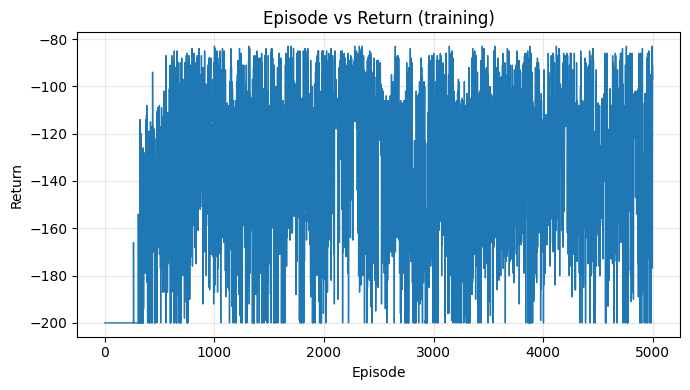

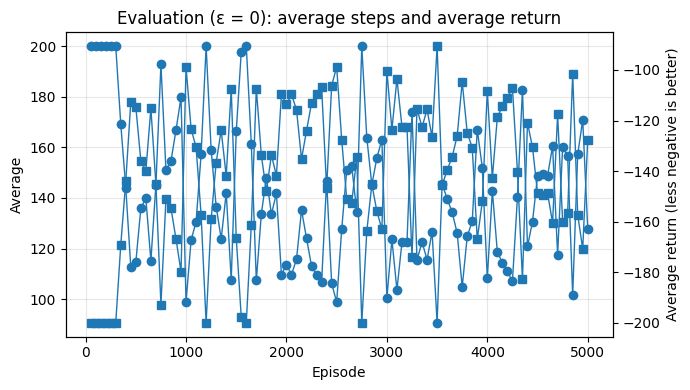

In [6]:
eval_every = 50
n_eval_episodes = 5


rewards_dqn = []         # training return per episode
eval_at_episode = []     # episode index of each evaluation
eval_avg_steps = []      # average steps-to-goal (lower is better)
eval_avg_returns = []    # average return (less negative is better)

def run_eval(n_episodes=5):
    """Evaluate with greedy policy (ε = 0.0)."""
    q_net.eval()
    steps_list, returns_list = [], []
    with torch.no_grad():
        for _ in range(n_episodes):
            state, _ = env.reset()
            done, steps, total_r = False, 0, 0.0
            while not done:
                a = epsilon_greedy(state, epsilon=0.0)
                next_state, r, terminated, truncated, _ = env.step(a)
                done = terminated or truncated
                state = next_state
                total_r += r
                steps += 1
            steps_list.append(steps)
            returns_list.append(total_r)
    q_net.train()
    return float(np.mean(steps_list)), float(np.mean(returns_list))


for episode in range(num_episodes):
    state, _ = env.reset()
    done, total_reward = False, 0.0

    while not done:
        action = epsilon_greedy(state, epsilon)


        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated


        replay_buffer.append((state, action, reward, next_state, float(done)))
        train_dqn()

        state = next_state
        total_reward += reward

    rewards_dqn.append(total_reward)


    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # periodic greedy evaluation
    if (episode + 1) % eval_every == 0:
        avg_steps, avg_ret = run_eval(n_eval_episodes)
        eval_at_episode.append(episode + 1)
        eval_avg_steps.append(avg_steps)
        eval_avg_returns.append(avg_ret)
        print(f"[Eval @ ep {episode+1}] avg_steps={avg_steps:.1f}, avg_return={avg_ret:.1f}, eps={epsilon:.3f}")


plt.figure(figsize=(7,4))
plt.plot(rewards_dqn, linewidth=1)
plt.title("Episode vs Return (training)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


if len(eval_at_episode) > 0:
    fig, ax1 = plt.subplots(figsize=(7,4))
    ax1.plot(eval_at_episode, eval_avg_steps, marker='o', linewidth=1)
    ax1.set_xlabel("Episode")
    ax1.set_ylabel("Average")
    ax1.set_title("Evaluation (ε = 0): average steps and average return")
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    ax2.plot(eval_at_episode, eval_avg_returns, marker='s', linewidth=1)
    ax2.set_ylabel("Average return (less negative is better)")
    fig.tight_layout()


# Exercise 2: Deep Q-Learning (DQN) on LunarLander-v2

## Problem Description
In this exercise, you will implement **Deep Q-Learning (DQN)** to solve the classic control problem **LunarLander-v2** in Gym.

### The Task
The agent controls a lander that starts at the top of the screen and must safely land on the landing pad between two flags.

- **State space**: Continuous vector of 8 variables, including:
  - Position (x, y)
  - Velocity (x_dot, y_dot)
  - Angle and angular velocity
  - Left/right leg contact indicators
- **Action space**: Discrete, 4 actions
  - 0: do nothing
  - 1: fire left orientation engine
  - 2: fire main engine
  - 3: fire right orientation engine
- **Rewards**:
  - +100 to +140 for successful landing
  - -100 for crashing
  - Small negative reward for firing engines (fuel cost)
  - Episode ends when lander crashes or comes to rest

The goal is to train an agent that lands successfully **most of the time**.

---

## Algorithm: Deep Q-Learning
You will implement a **DQN agent** with the following components:

1. **Q-Network**
   - Neural network that approximates Q(s, a).
   - Input: state vector (8 floats).
   - Output: Q-values for 4 actions.
   - Suggested architecture: 2 hidden layers with 128 neurons each, ReLU activation.

2. **Target Network**
   - A copy of the Q-network that is updated less frequently (e.g., every 1000 steps).
   - Used for stable target computation.

3. **Replay Buffer**
   - Stores transitions `(s, a, r, s_next, done)`.
   - Sample random mini-batches to break correlation between consecutive samples.

4. **ε-Greedy Policy**
   - With probability ε, take a random action.
   - Otherwise, take `argmax_a Q(s, a)`.
   - Decay ε over time (e.g., from 1.0 → 0.05).

5. **Q-Learning Method**
   


**Final note:**
   No code base is necessary. At this point, you must know how to implement evertything.
   For reference, but not recommended ([Here](https://colab.research.google.com/drive/1Gl0kuln79A__hgf2a-_-mwoGISXQDK_X?authuser=1#scrollTo=8Sd0q9DG8Rt8&line=56&uniqifier=1) is a solution)

---
## Deliverables
1. **Code**:
- Q-network (PyTorch).
- Training loop with ε-greedy policy, target network, and Adam optimizer.

2. **Plots**:
- Episode returns vs training episodes.
- Evaluation performance with a greedy policy (ε = 0).

3. **Short Write-up (≤1 page)**:
- Did your agent learn to land consistently?  
- How many episodes did it take before you saw improvement?  
- What effect did replay buffer size, target update frequency, and learning rate have on stability?  
- Compare results across different runs (does it sometimes fail to converge?).

Compare this task with the **MountainCar-v0** problem you solved earlier:
- What is **extra** or more challenging in LunarLander?  
- Consider state dimensionality, number of actions, reward shaping, and the difficulty of exploration.  
- Why might DQN be necessary here, whereas simpler methods (like tile coding) could work for MountainCar?
